# Data Mining Final: EEG Classification
by: Shalin Thomas


**Step 1: Data Preparation**

1. Import the base and peak CSV files and remove columns containing the string "Fp1_"
2. Combine base and peak data files into a single dataset and remove columns containing null values
3. Structure and combine data based on class 'consistent', 'misleading' and 'control' and add 'class' column (Target)
4. Plot the distribution of the target values to visualize the class balance.


**Step 2: Pre-processing**

1. Remove any outliers from the dataset.
2. Apply one-hot encoding to the time window columns.
3. Split the data into feature set (X) and target set (y) for training and testing.
3. Apply Min-Max scaling to normalize node values
4. Perform feature selection to reduce dimensionality and keep the most relevant features.

**Step 3: Building the Model**
1. Decision Tree
2. RandomForrest
3. Neural Networks
4. Naive Bayes

**Step 4: Evaluation**
1. Evaluate the model performance using the ROC curve to assess classification quality

### Step 0: Imports

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import classification_report
import altair as alt
from sklearn.metrics import RocCurveDisplay
# from google.colab import drive
# drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

### Step 1: Data Preparation

In [2]:
#1.1. Loading baseline data files which align in index.

# filepath_base = "/content/drive/My Drive/Colab Notebooks/baseline.csv"
# filepath_peak = "/content/drive/My Drive/Colab Notebooks/peak.csv"

filepath_base = r"data/baseline.csv"
filepath_peak = r"data/peak.csv"

df_raw_base = pd.read_csv(filepath_base).sort_values(by=['File','timeFiles'])

# 1.2. Drop the columns containing the string "Fp1_"
cols_to_drop = df_raw_base.columns[df_raw_base.columns.str.contains('Fp1_')]
df_raw_base.drop(cols_to_drop, axis=1, inplace=True)

# 1.3. Loading peak with peak data files which align in index.
df_raw_peak = pd.read_csv(filepath_peak).sort_values(by=['File','timeFiles'])

In [3]:
# 2. Combine base and peak files
pdList = [df_raw_base, df_raw_peak]
combined_df = df_raw_base.join(df_raw_peak.set_index(['timeFiles', 'File']), on=['timeFiles', 'File']).reset_index()
print(combined_df.shape)

# Drop rows with any null values
combined_df.dropna(inplace=True)
print("After dropping null values")
print(combined_df.shape)

(125, 273)
After dropping null values
(100, 273)


In [4]:
# 3.1 Function to extract columns by a specific pattern
def extract_columns(df, pattern):
    return [col for col in df.columns if re.search(pattern, col)]

common = ["timeFiles", "File"]

# Extract column groups based on pattern
base_col_consistent = extract_columns(combined_df, r"BaselineCorrectionCONSISTENT$")
base_col_misleading = extract_columns(combined_df, r"BaselineCorrectionMISLEADING$")
base_col_control = extract_columns(combined_df, r"BaselineCorrectionCONTROL$")

peakV_col_consistent = extract_columns(combined_df, r"PeakDetection_Consistent-V$")
peakV_col_misleading = extract_columns(combined_df, r"PeakDetection_Misleading-V$")
peakV_col_control = extract_columns(combined_df, r"PeakDetection_Control-V$")

peakL_col_consistent = extract_columns(combined_df, r"PeakDetection_Consistent-L$")
peakL_col_misleading = extract_columns(combined_df, r"PeakDetection_Misleading-L$")
peakL_col_control = extract_columns(combined_df, r"PeakDetection_Control-L$")

# # 3.2 Create Columns per class [consistent, misleading, control]
col_consistent = common + base_col_consistent + peakV_col_consistent + peakL_col_consistent
col_misleading = common + base_col_misleading + peakV_col_misleading + peakL_col_misleading
col_control = common + base_col_control + peakV_col_control + peakL_col_control

# 3.3 Final common columns names for all DF classes
columns = [i.replace('consistent', '') for i in combined_df[col_consistent].columns.str.lower()]

# 3.4 DF for each class [consistent, misleading, control]
df_consistent = combined_df[col_consistent]
df_consistent.columns = columns
df_consistent['class'] = ['consistent' for i in range(0,len(df_consistent))]

df_misleading = combined_df[col_misleading]
df_misleading.columns = columns
df_misleading['class'] = ['misleading' for i in range(0,len(df_misleading))]

df_control = combined_df[col_control]
df_control.columns = columns
df_control['class'] = ['control' for i in range(0,len(df_control))]

#### Data Visualization

In [5]:
# 4.1 Stack data with created class Variable
all_stacked_combined_df = pd.concat([
    df_consistent,
    df_misleading,
    df_control
], ignore_index=True)

stacked_combined_df_X = all_stacked_combined_df.iloc[:,3:-1]
stacked_combined_df_y = all_stacked_combined_df.iloc[:,-1]

n_components=2

# 4.2 Apply pipelien to perform Standardization and PCA for top 2 components
pipe = Pipeline([('scaler', MinMaxScaler()), ('pca', PCA(n_components=n_components))])
df_pca = pipe.fit_transform(stacked_combined_df_X)

df_pca = pd.concat(
    [
    pd.DataFrame(df_pca,
                 columns=[f"PC{i+1}" for i in range(n_components)]
                 ),
    stacked_combined_df_y
  ], axis=1
)

# 4.3 Using scatterplot to display output for the 3 classes
alt.Chart(df_pca).mark_point().encode(
    x='PC1',
    y='PC2',
    color='class',
)

alt.Chart(...)

Since Consistent, Control and misleading seem to have similar in characteristics, Remove 1-class to treat as binary problem, as there is no clear way for seperation after performing PCA. [class= consistent] was removed from the data.We shall consider binary classification using Misleading[true=misleading, false=Control]

In [6]:
stacked_combined_df = pd.concat([df_misleading,df_control], ignore_index=True)

### Step 2: Preprocessing

In [7]:
# 1. Remove outlier > 3 and < 3 std dev either side
df_final = stacked_combined_df[
    (np.abs(stats.zscore(stacked_combined_df.iloc[:,3:-1])) < 3).all(axis=1)
    ]

df_final = stacked_combined_df[(np.abs(stats.zscore(stacked_combined_df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]
print(f"Data shape after outlier removal: {df_final.shape}")

Data shape after outlier removal: (178, 93)


In [8]:
# 2. One-hot encoding for time files to convert categorical variable to numeric
df_final = pd.get_dummies(df_final, columns=['timefiles'], dtype=int)
df_final.head()

,file,fz_baselinecorrection,f3_baselinecorrection,f7_baselinecorrection,ft9_baselinecorrection,fc5_baselinecorrection,fc1_baselinecorrection,c3_baselinecorrection,t7_baselinecorrection,tp9_baselinecorrection,...,fc6-peakdetection_-l,fc2-peakdetection_-l,f4-peakdetection_-l,f8-peakdetection_-l,fp2-peakdetection_-l,class,timefiles_150275,timefiles_150350,timefiles_250400,timefiles_300500
0,Training_000018,1.535197,7.157780,25.305492,11.543356,12.764351,3.893413,5.447718,6.562185,2.038946,...,150.0,168.0,158.0,150.0,150.0,misleading,1,0,0,0
1,Training_000018,0.744513,6.091435,25.106804,12.220854,12.368675,2.199412,4.391621,6.491111,2.513568,...,234.0,246.0,240.0,218.0,238.0,misleading,0,1,0,0
2,Training_000018,-1.112303,4.000510,22.719759,13.067228,10.335864,-0.495400,2.437691,4.794047,4.176258,...,352.0,396.0,394.0,352.0,350.0,misleading,0,0,1,0
3,Training_000018,-0.826402,3.869941,19.260611,12.037136,9.710368,0.573547,3.318691,5.528087,4.216319,...,446.0,442.0,446.0,446.0,440.0,misleading,0,0,0,1
4,Training_000019_002,-0.906383,-1.550627,-4.380054,-3.364596,-2.380489,-0.440141,-0.177573,-1.799481,-1.700526,...,164.0,154.0,152.0,158.0,166.0,misleading,1,0,0,0


In [9]:
# 3. Split data into feature (X) and target (y)
X = df_final.drop(columns=['class','file'])  # Features
y = df_final['class']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Using misleading for binary classification
y_train_copy = y_train
y_train_copy = pd.get_dummies(y_train_copy, columns=['class'], drop_first=True).reset_index().drop(columns=['index'])
y_train_copy.columns=['class_misleading']

y_test_copy = y_test
y_test_copy = pd.get_dummies(y_test_copy, columns=['class'], drop_first=True).reset_index().drop(columns=['index'])
y_test_copy.columns=['class_misleading']

In [11]:
# 4. min-max scaling for nodes
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#### Feature Selection:


In [12]:
# 5.1 Create a decision tree classifier
estimator = DecisionTreeClassifier(random_state=42)

# 5.2 Use RFE to find the top optimal features
selector = RFE(estimator, n_features_to_select=3)
selector = selector.fit(X_train_scaled, y_train_copy)
selected_features = X_train_scaled.columns[selector.support_]

# 5.3 Print the optimal features
print("Optimal number of features: %d" % selector.n_features_)
print("Selected features: %s" % selected_features)

Optimal number of features: 3
Selected features: Index(['o2_baselinecorrection', 'cp2_baselinecorrection',
       'f8-peakdetection_-v'],
      dtype='object')


In [13]:
# Filter X_train and X_test to include only the selected features
X_train_feature = X_train_scaled[selected_features]
X_test_feature = X_test_scaled[selected_features]

# Verify the shape of the filtered datasets
print("Shape of X_train_selected:", X_train_feature.shape)
print("Shape of X_test_selected:", X_test_feature.shape)

Shape of X_train_selected: (142, 3)
Shape of X_test_selected: (36, 3)


In [14]:
# Combine selected features and target into a single DataFrame
df = pd.concat([X_train_scaled.iloc[:, selector.support_], y_train_copy], axis=1)

# Scatterplot chart for the first two features
chart1 = alt.Chart(df).mark_point(size=60, opacity=0.7).encode(
    x=alt.X(df.columns[0], title=f"{df.columns[0]} (X-axis)"),
    y=alt.Y(df.columns[1], title=f"{df.columns[1]} (Y-axis)"),
    color=alt.Color('class_misleading', scale=alt.Scale(), title="Class"),
).properties(
    title=f"Scatter Plot: {df.columns[0]} vs {df.columns[1]}",
    width=400,
    height=300
)

chart1

alt.Chart(...)

### Step 3: Model

#### Decision Tree:

In [15]:
# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42, splitter='best')

# Parameter distributions
param_distributions = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'criterion': ['gini', 'entropy']
}

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_distributions,
                                   n_iter=50, cv=3, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train_feature, y_train_copy)

# Print the best parameters and results
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Select the best parameters for the model
best_dd = random_search.best_estimator_
print("Best estimator: ", best_dd)

# Evaluate Performance
y_train_pred_T = best_dd.predict(X_train_feature)
y_test_pred_T = best_dd.predict(X_test_feature)

print("Training Performance:")
print(classification_report(y_train_copy, y_train_pred_T))

print("\nValidation Performance:")
print(classification_report(y_test_copy, y_test_pred_T))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best Cross-Validation Score: 0.5285165484633569
Best estimator:  DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=5,
                       random_state=42)
Training Performance:
              precision    recall  f1-score   support

       False       0.79      0.75      0.77        71
        True       0.76      0.80      0.78        71

    accuracy                           0.77       142
   macro avg       0.78      0.77      0.77       142
weighted avg       0.78      0.77      0.77       142


Validation Performance:
              precision    recall  f1-score   support

       False       0.50      0.44      0.47        16
        True       0.59      0.65      0.62        20

    accuracy                           0.56        36
   macro avg       0.55      0.54      0.54        36
weighted

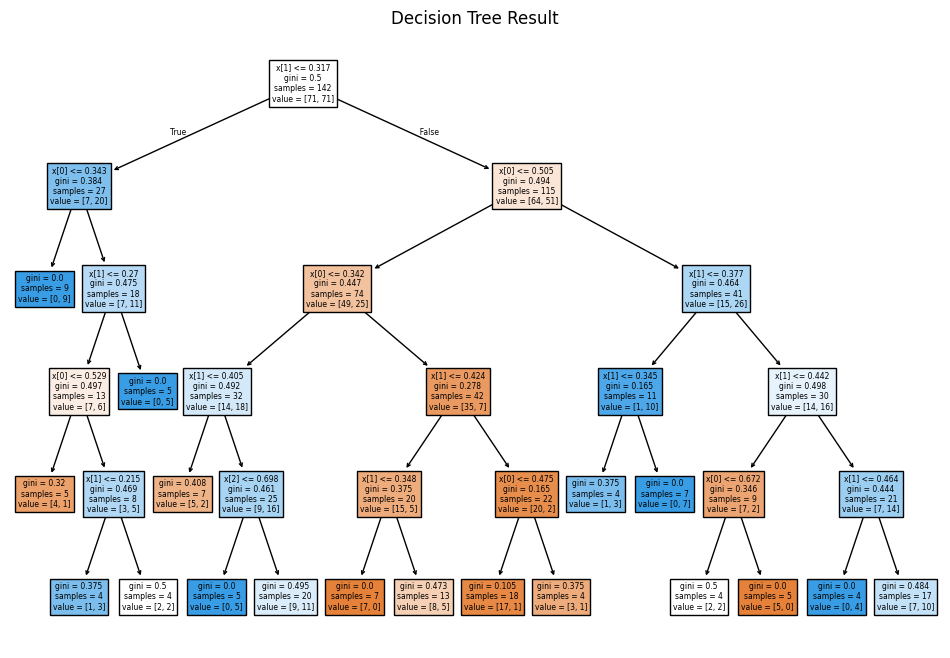

In [16]:
plt.figure(figsize=(12, 8))
plot_tree(best_dd, filled=True)
plt.title("Decision Tree Result")
plt.show()

#### Random Forest Classifier:

In [17]:
# Initialize the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

param_distributions = {
    'n_estimators': randint(50, 100),
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'criterion': ['gini', 'entropy']
}

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_distributions,
                                   n_iter=50, cv=3, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train_feature, y_train_copy)

# Print the best parameters and results
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Select the best parameters for the model
best_rf = random_search.best_estimator_
print("Best estimator: ", best_rf)

# Evaluate Performance
y_train_pred_T = best_rf.predict(X_train_feature)
y_test_pred_T = best_rf.predict(X_test_feature)

print("Training Performance:")
print(classification_report(y_train_copy, y_train_pred_T))

print("\nValidation Performance:")
print(classification_report(y_test_copy, y_test_pred_T))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 85}
Best Cross-Validation Score: 0.5143321513002365
Best estimator:  RandomForestClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=6,
                       n_estimators=85, random_state=42)
Training Performance:
              precision    recall  f1-score   support

       False       0.93      0.90      0.91        71
        True       0.90      0.93      0.92        71

    accuracy                           0.92       142
   macro avg       0.92      0.92      0.92       142
weighted avg       0.92      0.92      0.92       142


Validation Performance:
              precision    recall  f1-score   support

       False       0.39      0.44      0.41        16
        True       0.50      0.45      0.47        20

    accuracy                           0.44        36
   macro avg       0.44

#### Neural Networks (NN)

In [18]:
# Initialize the MLPClassifier
NN = MLPClassifier(random_state=42, max_iter=500)

param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (5, 5), (10, 5)],
    'activation': ['relu', 'logistic', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.01, 0.001],
    'learning_rate': ['constant', 'adaptive'],
}

grid_search = GridSearchCV(NN, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_feature, y_train_copy)

# Get the best parameters and best estimator
print("Best parameters: ", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Select the best parameters for the model
best_NN = grid_search.best_estimator_
print("Best estimator: ", best_NN)

# Make predictions
y_train_pred_NN = best_NN.predict(X_train_feature)
y_pred_NN = best_NN.predict(X_test_feature)

print("Training Performance:")
print(classification_report(y_train_copy, y_train_pred_NN))

print("\Validation Performance:")
print(classification_report(y_test_copy, y_pred_NN))

Best parameters:  {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (10, 5), 'learning_rate': 'constant', 'solver': 'adam'}
Best Cross-Validation Score: 0.5645320197044335
Best estimator:  MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(10, 5),
              max_iter=500, random_state=42)
Training Performance:
              precision    recall  f1-score   support

       False       0.56      0.62      0.59        71
        True       0.57      0.51      0.54        71

    accuracy                           0.56       142
   macro avg       0.56      0.56      0.56       142
weighted avg       0.56      0.56      0.56       142

\Validation Performance:
              precision    recall  f1-score   support

       False       0.47      0.50      0.48        16
        True       0.58      0.55      0.56        20

    accuracy                           0.53        36
   macro avg       0.52      0.53      0.52        36
weighted avg       0.53      0.53    

#### Naive Bayes

In [19]:
# Initialize the Naive bayes
NB = GaussianNB(priors=[0.5, 0.5])
NB.fit(X_train_feature, y_train_copy)
y_train_pred_NB = NB.predict(X_train_feature)
y_test_pred_NB = NB.predict(X_test_feature)

print("Training Performance:")
print(classification_report(y_train_copy, y_train_pred_NB))

print("Validation Performance:")
print(classification_report(y_test_copy, y_test_pred_NB))

Training Performance:
              precision    recall  f1-score   support

       False       0.56      0.73      0.63        71
        True       0.61      0.42      0.50        71

    accuracy                           0.58       142
   macro avg       0.59      0.58      0.57       142
weighted avg       0.59      0.58      0.57       142

Validation Performance:
              precision    recall  f1-score   support

       False       0.44      0.75      0.56        16
        True       0.56      0.25      0.34        20

    accuracy                           0.47        36
   macro avg       0.50      0.50      0.45        36
weighted avg       0.51      0.47      0.44        36



### Step 4: Evaluation (ROC Curve)

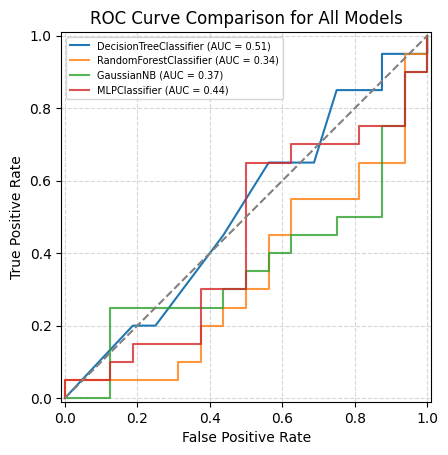

In [20]:
# Decision Tree
tree_disp = RocCurveDisplay.from_estimator(best_dd, X_test_feature, y_test_copy)

# Random Forest
ax = plt.gca()
rf_disp = RocCurveDisplay.from_estimator(best_rf, X_test_feature, y_test_copy, ax=ax, alpha=0.8)

# Naive Bayes
ax = plt.gca()
NB_disp = RocCurveDisplay.from_estimator(NB, X_test_feature, y_test_copy, ax=ax, alpha=0.8)

# Neural Network
ax = plt.gca()
NN_disp = RocCurveDisplay.from_estimator(best_NN, X_test_feature, y_test_copy, ax=ax, alpha=0.8)

# Chance level
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title("ROC Curve Comparison for All Models")
plt.legend(loc="upper left", fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("False Positive Rate", fontsize=10)
plt.ylabel("True Positive Rate", fontsize=10)
plt.show()

#### Conclusion:

Based on the model performance and AUC scores, none of the models outperformed random guessing. This suggests that either additional research data is required, or there may not be any distinguishing features that can effectively differentiate between the classes. Further investigation is necessary to improve the model's predictive capability.